In [104]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

In [8]:

def paint_rectangle(image_path, top_left, bottom_right, output_path="output_image.png"):
    """
    Paints a rectangle in red over the image.

    Parameters:
    - image_path (str): Path to input image.
    - top_left (tuple): (x, y) of top-left corner.
    - bottom_right (tuple): (x, y) of bottom-right corner.
    - output_path (str): Path to save modified image.
    """
    img = cv2.imread(image_path)

    if img is None:
        raise IOError("Error: Could not read image.")

    # BGR format → Red = (0,0,255)
    cv2.rectangle(img, top_left, bottom_right, (0, 0, 255), thickness=-1)  # -1 = filled rectangle

    cv2.imwrite(output_path, img)

    cv2.imshow("Rectangle painted", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [14]:
paint_rectangle('2025-09-09-155110.jpg', (700, 320), (750, 360))

In [38]:
def extract_rgb_signals_rect(video_path, rect, output_csv="rgb_signals.csv"):
    """
    Extracts mean R, G, B signals from all pixels inside a rectangle across video frames.

    Parameters:
    - video_path (str): Path to input video.
    - rect (tuple): (x1, y1, x2, y2) defining the rectangle (top-left to bottom-right).
    - output_csv (str): Output CSV filename.
    """
    x1, y1, x2, y2 = rect
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Error opening video file.")

    signals = {"Mean_R": [], "Mean_G": [], "Mean_B": []}
    frames = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames += 1

        roi = frame[y1:y2, x1:x2]

        mean_b = np.mean(roi[:, :, 0])
        mean_g = np.mean(roi[:, :, 1])
        mean_r = np.mean(roi[:, :, 2])

        signals["Mean_R"].append(mean_r)
        signals["Mean_G"].append(mean_g)
        signals["Mean_B"].append(mean_b)

    cap.release()
    print(frames)

    df = pd.DataFrame(signals)
    df.to_csv(output_csv, index=False)

    return df

In [37]:
extract_rgb_signals_rect("2025-09-09-155113.webm", (615, 175, 700, 215), output_csv="rgb_signals.csv")

298


[ WARN:0@1415.707] global cap_ffmpeg_impl.hpp:1541 grabFrame packet read max attempts exceeded, if your video have multiple streams (video, audio) try to increase attempt limit by setting environment variable OPENCV_FFMPEG_READ_ATTEMPTS (current value is 4096)


,Mean_R,Mean_G,Mean_B
0,123.870294,74.538529,69.206765
1,123.870294,74.538529,69.206765
2,123.870588,74.538824,69.207059
3,123.870588,74.538824,69.207059
4,123.870882,74.539118,69.207353
...,...,...,...
293,125.265000,75.405882,70.358824
294,124.881765,75.575000,70.348529
295,124.771176,75.619706,70.335588
296,124.562353,75.415588,70.131471


In [128]:
def plot_rgb_signals(df, fps=30):
    """
    Plot R, G, B signals in time and frequency domains using subplots.

    Parameters:
    - df (pd.DataFrame): DataFrame with extracted mean signals.
    - fps (int): Frames per second of the video.
    """
    r = df["Mean_R"].values
    g = df["Mean_G"].values
    b = df["Mean_B"].values

    n = len(r)
    t = np.arange(n) / fps

    freqs = np.fft.rfftfreq(n, d=1/fps)
    r_fft = np.abs(np.fft.rfft(r - np.mean(r)))
    g_fft = np.abs(np.fft.rfft(g - np.mean(g)))
    b_fft = np.abs(np.fft.rfft(b - np.mean(b)))

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle("RGB Signals (raw)", fontsize=14)

    axes[0, 0].plot(t, r, color='red')
    axes[0, 0].set_title('R - Time')
    axes[0, 0].set_ylabel('Intensity')

    axes[1, 0].plot(t, g, color='green')
    axes[1, 0].set_title('G - Time')
    axes[1, 0].set_ylabel('Intensity')

    axes[2, 0].plot(t, b, color='blue')
    axes[2, 0].set_title('B - Time')
    axes[2, 0].set_xlabel('Time (s)')
    axes[2, 0].set_ylabel('Intensity')

    axes[0, 1].plot(freqs, r_fft, color='red')
    axes[0, 1].set_title('R - Frequency')

    axes[1, 1].plot(freqs, g_fft, color='green')
    axes[1, 1].set_title('G - Frequency')

    axes[2, 1].plot(freqs, b_fft, color='blue')
    axes[2, 1].set_title('B - Frequency')
    axes[2, 1].set_xlabel('Frequency (Hz)')

    for ax in axes[:, 1]:
        ax.set_xlim(0, 5)  
        ax.set_ylabel('Magnitude')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [52]:
df = pd.read_csv('rgb_signals.csv')

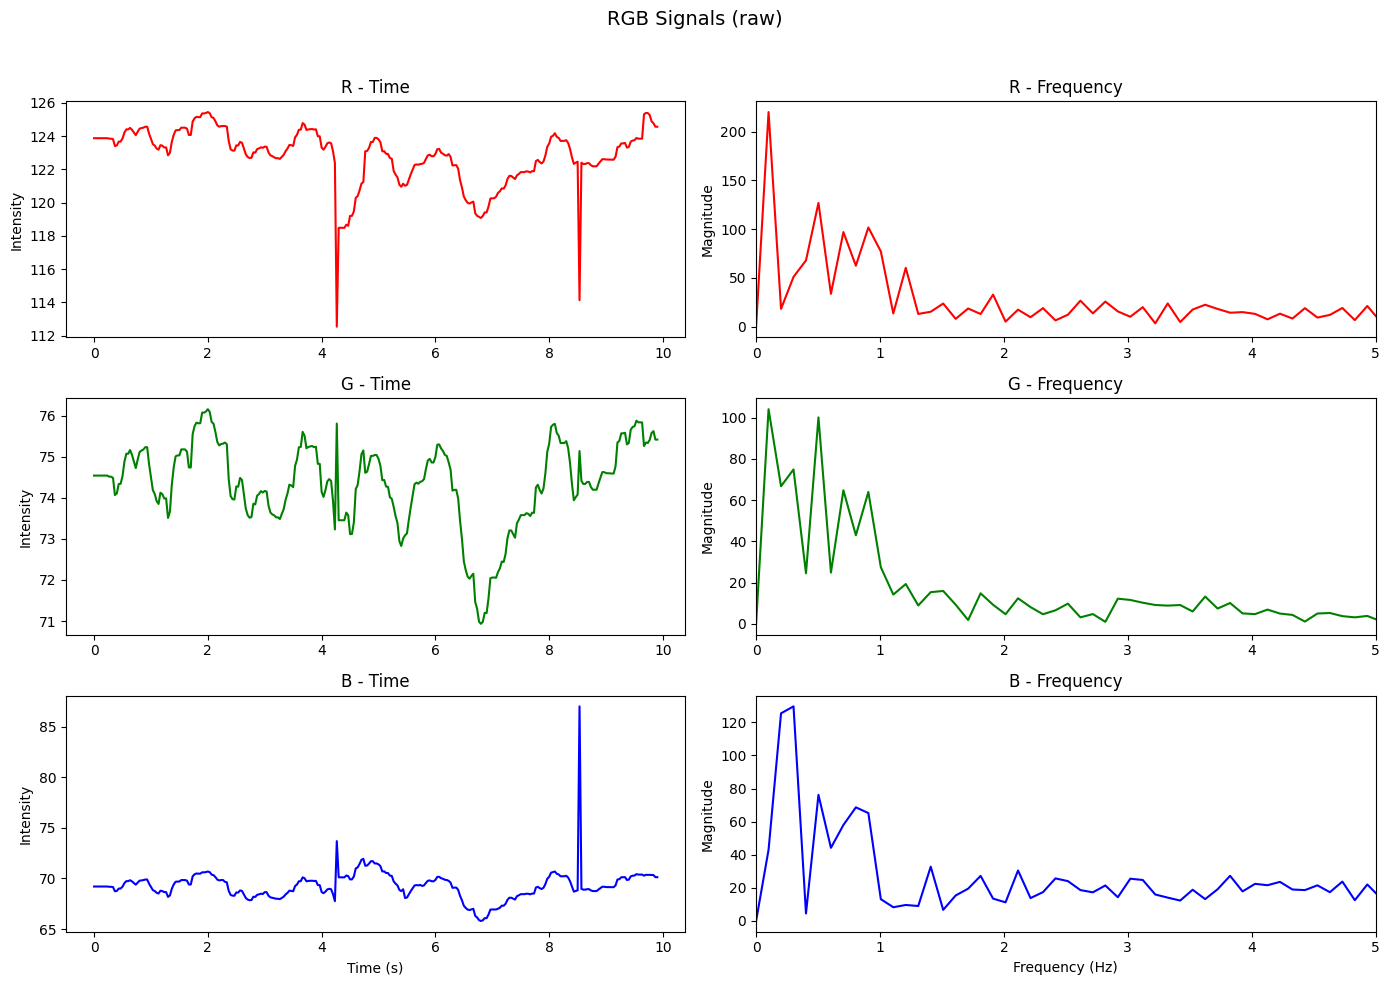

In [129]:
plot_rgb_signals(df)

In [155]:
paint_rectangle('android.jpeg', (750, 175), (875, 250))

In [49]:
extract_rgb_signals_rect("android.mp4", (750, 175, 875, 250), output_csv="rgb_signals_android.csv");

1218


In [141]:
extract_rgb_signals_rect("android.mp4", (1150, 175, 1375, 450), output_csv="rgb_signals_control.csv");

1218


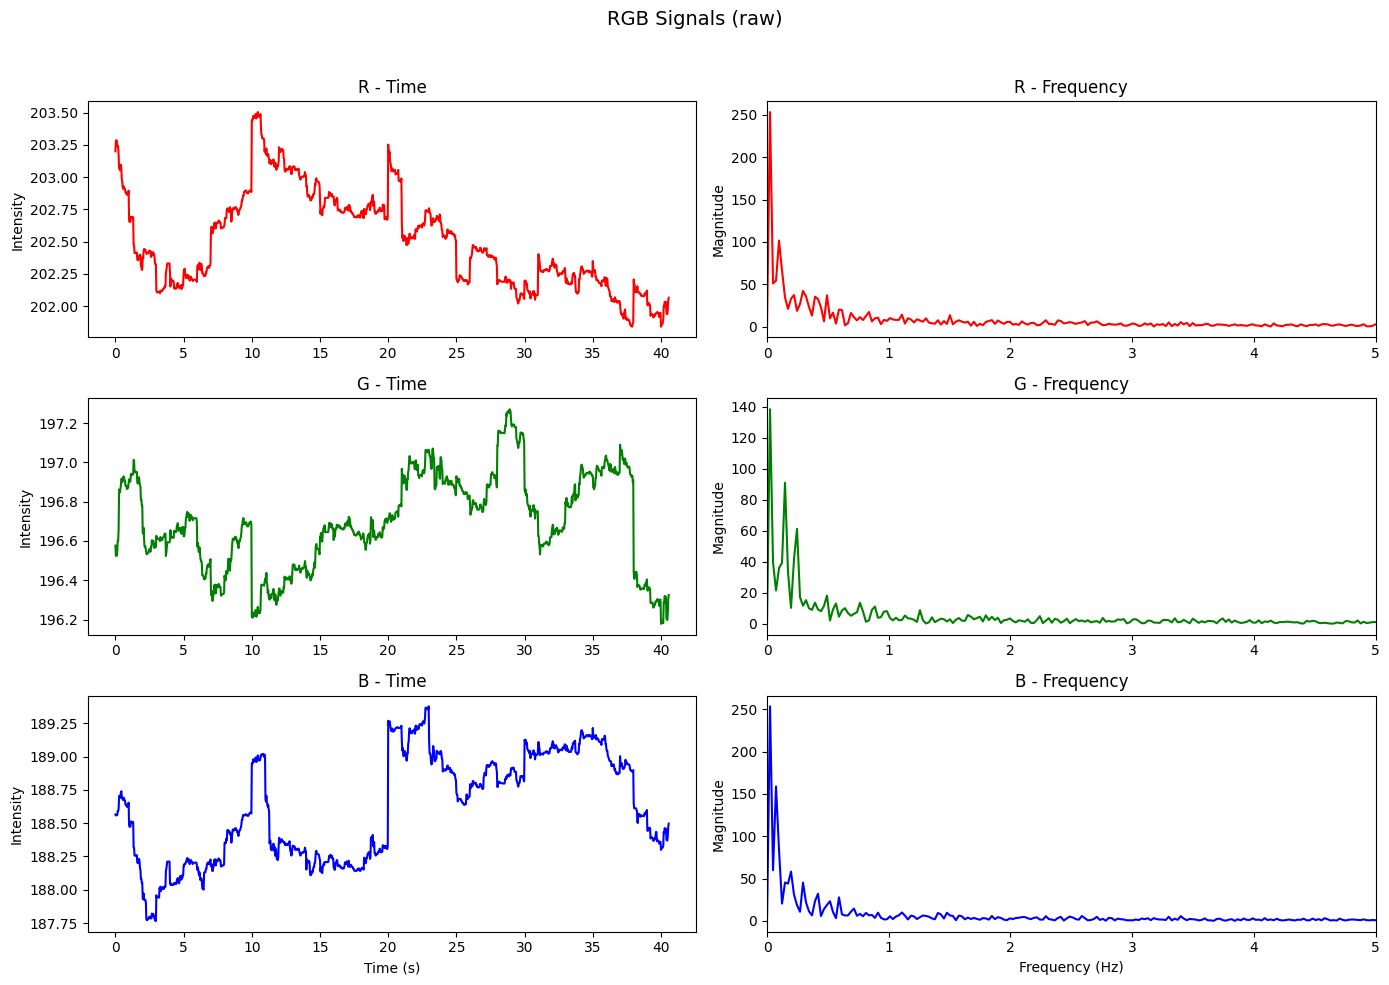

In [130]:
plot_rgb_signals(pd.read_csv('rgb_signals_android.csv'))

In [109]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def plot_filtered_signals(df, lowcut, highcut, filter_order=4, fps=30):
    """
    Plot filtered R, G, B signals in time and frequency domains (3x2 subplots)
    and also plot their spectrograms.
    """
    r_raw = df["Mean_R"].values
    g_raw = df["Mean_G"].values
    b_raw = df["Mean_B"].values

    r = butter_bandpass_filter(r_raw, lowcut, highcut, fs=fps, order=filter_order)
    g = butter_bandpass_filter(g_raw, lowcut, highcut, fs=fps, order=filter_order)
    b = butter_bandpass_filter(b_raw, lowcut, highcut, fs=fps, order=filter_order)

    n = len(r)
    t = np.arange(n) / fps

    freqs = np.fft.rfftfreq(n, d=1/fps)
    r_fft = np.abs(np.fft.rfft(r - np.mean(r)))
    g_fft = np.abs(np.fft.rfft(g - np.mean(g)))
    b_fft = np.abs(np.fft.rfft(b - np.mean(b)))

    # === Time & Frequency plots ===
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f"RGB Signals (filtered {lowcut}-{highcut} Hz)", fontsize=14)

    axes[0,0].plot(t, r, color='red')
    axes[0,0].set_title('R - Time')
    axes[0,0].set_ylabel('Intensity')
    
    axes[1,0].plot(t, g, color='green')
    axes[1,0].set_title('G - Time')
    axes[1,0].set_ylabel('Intensity')
    
    axes[2,0].plot(t, b, color='blue')
    axes[2,0].set_title('B - Time')
    axes[2,0].set_xlabel('Time (s)')
    axes[2,0].set_ylabel('Intensity')

    axes[0,1].plot(freqs, r_fft, color='red')
    axes[0,1].set_title('R - Frequency')
    
    axes[1,1].plot(freqs, g_fft, color='green')
    axes[1,1].set_title('G - Frequency')
    
    axes[2,1].plot(freqs, b_fft, color='blue')
    axes[2,1].set_title('B - Frequency')
    axes[2,1].set_xlabel('Frequency (Hz)')

    for ax in axes[:,1]:
        ax.set_xlim(0, 5)  
        ax.set_ylabel('Magnitude')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # === Spectrograms ===
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
    fig.suptitle(f"Spectrograms of Filtered RGB Signals ({lowcut}-{highcut} Hz)", fontsize=14)

    signals = [(r, 'R', 'Reds'), (g, 'G', 'Greens'), (b, 'B', 'Blues')]
    for ax, (sig, label, cmap) in zip(axes, signals):
        f, tt, Sxx = spectrogram(sig, fs=fps, nperseg=256, noverlap=128)
        im = ax.pcolormesh(tt, f, 10*np.log10(Sxx+1e-12), shading='gouraud', cmap=cmap)
        ax.set_ylabel('Freq (Hz)')
        ax.set_ylim(0, 5)
        ax.set_title(f'{label} channel')
        fig.colorbar(im, ax=ax, orientation='vertical', label='Power (dB)')

    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

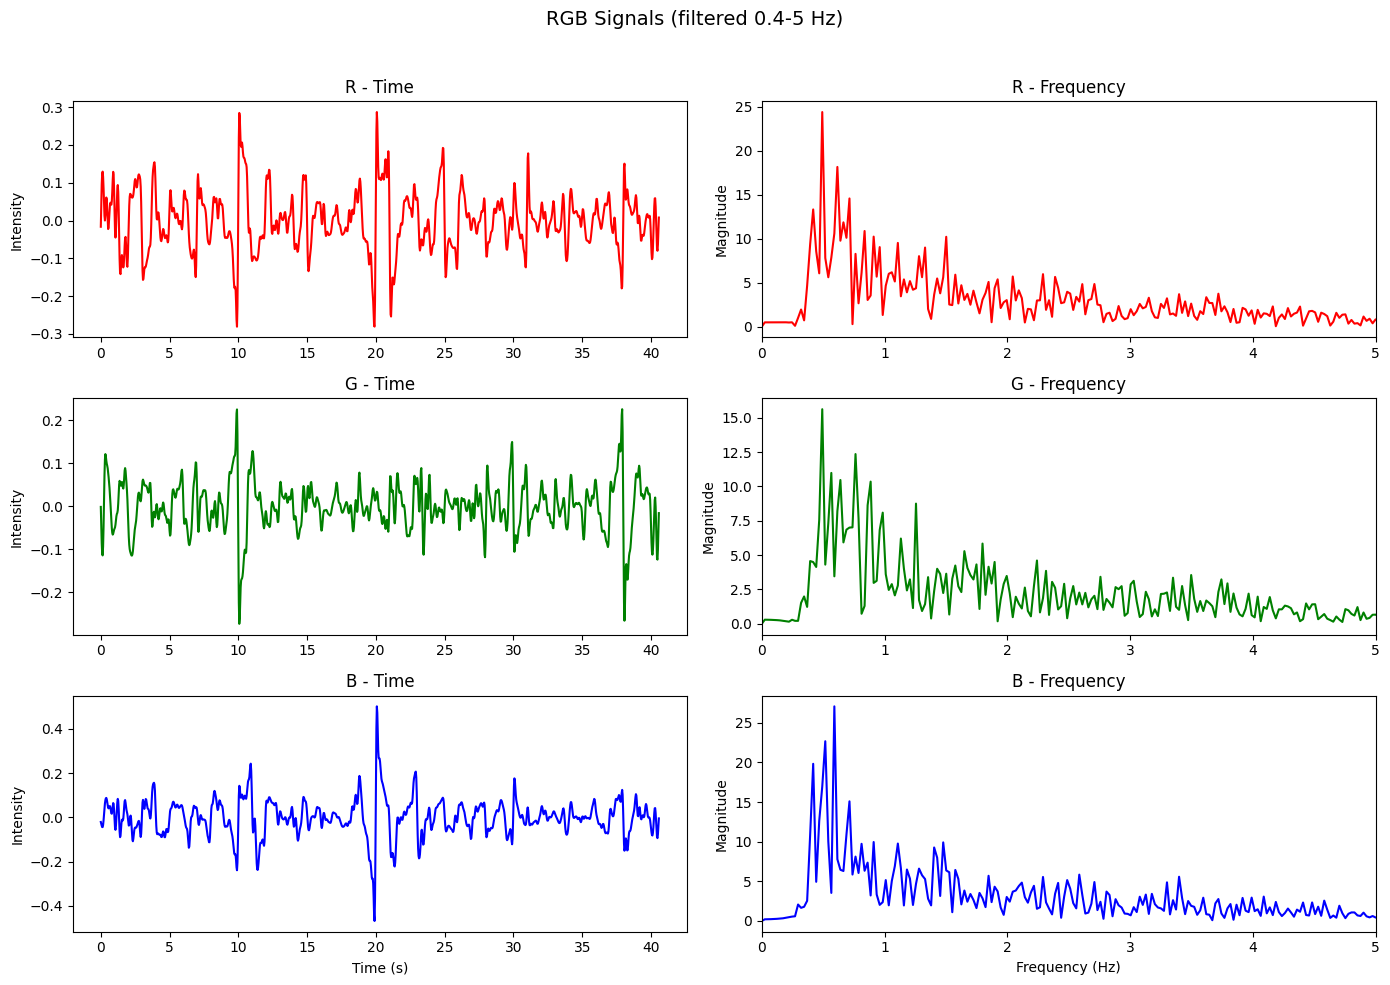

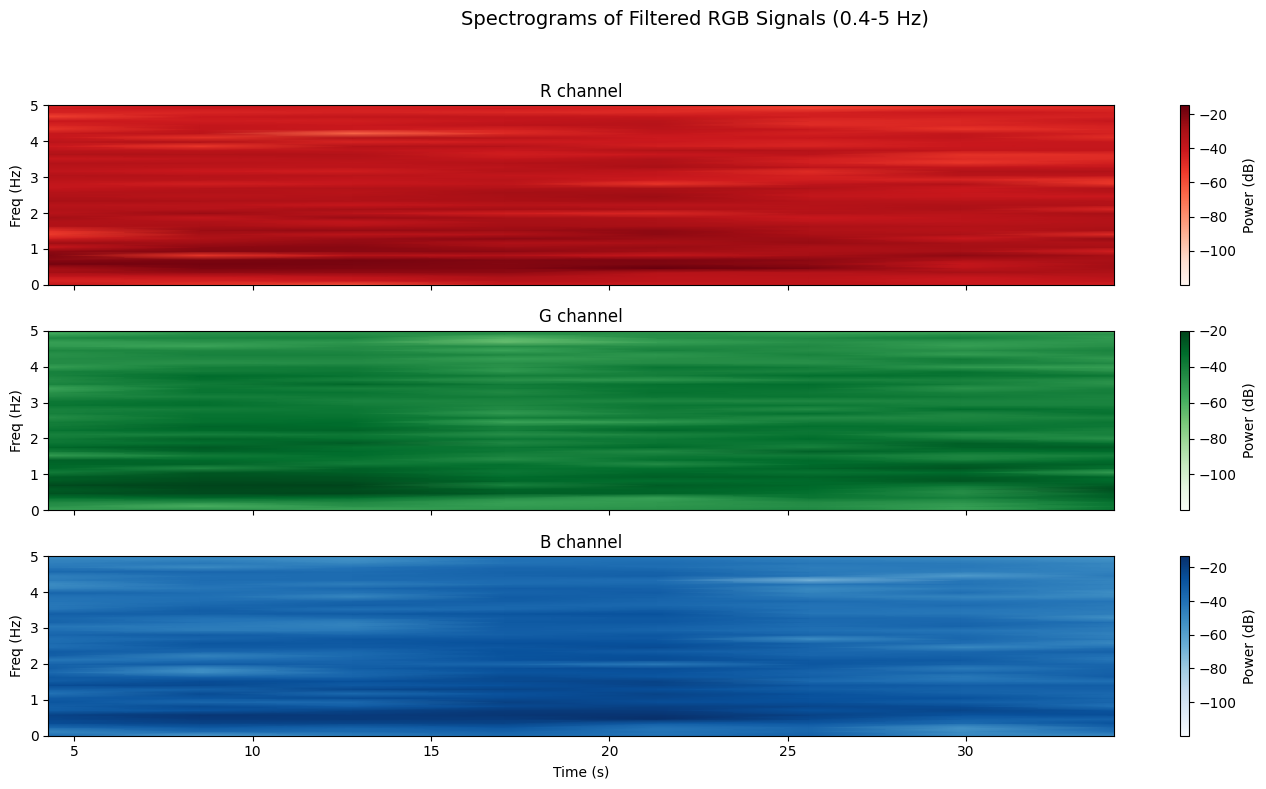

In [115]:
plot_filtered_signals(pd.read_csv('rgb_signals_android.csv'), 0.4, 5, 5)

In [ ]:
def show_power_map_roi(video_path, frame_index, roi, channel=None):
    """
    Display a power map of a rectangular ROI in a video frame,
    and show the original frame with the ROI outlined.

    Parameters:
        video_path (str): Path to video.
        frame_index (int): Frame number to extract.
        roi (tuple): (x1, y1, x2, y2) coordinates of the rectangle.
        channel (str or None): 'R', 'G', 'B' to select a channel for power map, None = grayscale.
    """
    x1, y1, x2, y2 = roi

    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Could not read frame {frame_index}")
        return

    frame_with_roi = frame.copy()
    cv2.rectangle(frame_with_roi, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Select channel
    if channel == 'R':
        frame_data = frame[:, :, 2]
    elif channel == 'G':
        frame_data = frame[:, :, 1]
    elif channel == 'B':
        frame_data = frame[:, :, 0]
    else:
        frame_data = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    roi_data = frame_data[y1:y2, x1:x2]

    # Compute power map
    power_map = np.square(roi_data.astype(np.float32))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cv2.cvtColor(frame_with_roi, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Frame {frame_index} with ROI")
    axes[0].axis('off')

    im = axes[1].imshow(power_map, cmap='hot')
    axes[1].set_title(f"Power map - ROI {roi} ({'Grayscale' if channel is None else channel})")
    axes[1].axis('off')
    fig.colorbar(im, ax=axes[1], orientation='vertical', label='Power')

    plt.tight_layout()
    plt.show()

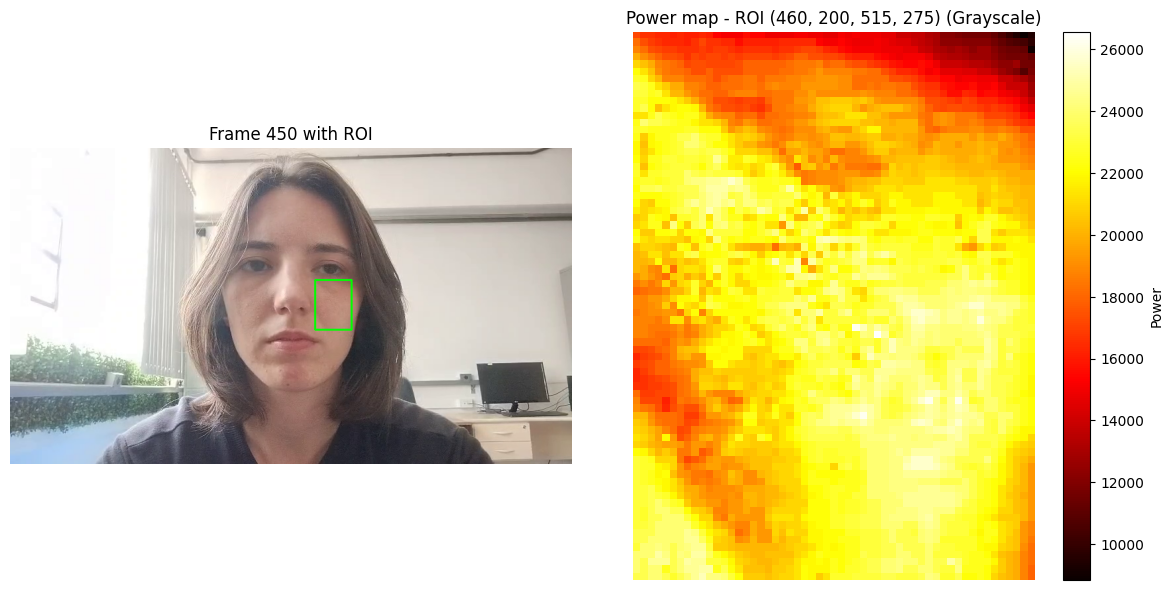

In [221]:
show_power_map_roi('android.mp4', 450, (460, 200, 515, 275), channel=None)

In [ ]:
def save_video_with_powermap(video_path, output_path, roi, channel=None, fps=None):
    """
    Create a new video showing the original frame (full size) and its ROI power map
    beside it. The power map is resized to half the original height while maintaining aspect ratio.

    Parameters:
        video_path (str): Path to input video.
        output_path (str): Path to save output video.
        roi (tuple): (x1, y1, x2, y2) ROI coordinates.
        channel (str or None): 'R', 'G', 'B' to select channel, None = grayscale.
        fps (int or None): Frames per second of output video. If None, uses input video fps.
    """
    x1, y1, x2, y2 = roi

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Cannot open video {video_path}")
        return

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if fps is None:
        fps = cap.get(cv2.CAP_PROP_FPS)

    print(f"Processing {n_frames} frames...")

    target_height = height // 2

    out_width = None
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = None

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_with_roi = frame.copy()
        cv2.rectangle(frame_with_roi, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        if channel == 'R':
            frame_data = frame[:, :, 2]
        elif channel == 'G':
            frame_data = frame[:, :, 1]
        elif channel == 'B':
            frame_data = frame[:, :, 0]
        else:
            frame_data = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        roi_data = frame_data[y1:y2, x1:x2]
        power_map = np.square(roi_data.astype(np.float32))

        power_map_norm = cv2.normalize(power_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        power_map_color = cv2.applyColorMap(power_map_norm, cv2.COLORMAP_HOT)

        h, w = power_map_color.shape[:2]
        scale_factor = target_height / h
        new_w = int(w * scale_factor)
        power_map_resized = cv2.resize(power_map_color, (new_w, target_height))

        padded_power_map = np.zeros((height, new_w, 3), dtype=np.uint8)
        y_offset = (height - target_height) // 2
        padded_power_map[y_offset:y_offset+target_height, :, :] = power_map_resized

        combined_frame = np.hstack((frame_with_roi, padded_power_map))

        if out is None:
            out_width = combined_frame.shape[1]
            out = cv2.VideoWriter(output_path, fourcc, fps, (out_width, height))

        out.write(combined_frame)

        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f"Processed {frame_idx}/{n_frames} frames")

    cap.release()
    if out:
        out.release()
    print(f"Saved power map video to {output_path}")

In [235]:
save_video_with_powermap('android.mp4', 'powermap.mp4', (400, 75, 450, 125), channel='G', fps=30)

Processing 1218 frames...
Processed 50/1218 frames
Processed 100/1218 frames
Processed 150/1218 frames
Processed 200/1218 frames
Processed 250/1218 frames
Processed 300/1218 frames
Processed 350/1218 frames
Processed 400/1218 frames
Processed 450/1218 frames
Processed 500/1218 frames
Processed 550/1218 frames
Processed 600/1218 frames
Processed 650/1218 frames
Processed 700/1218 frames
Processed 750/1218 frames
Processed 800/1218 frames
Processed 850/1218 frames
Processed 900/1218 frames
Processed 950/1218 frames
Processed 1000/1218 frames
Processed 1050/1218 frames
Processed 1100/1218 frames
Processed 1150/1218 frames
Processed 1200/1218 frames
Saved power map video to powermap.mp4


In [234]:
save_video_with_powermap('android.mp4', 'powermapbochecha.mp4', (460, 200, 515, 275), channel='G', fps=30)

Processing 1218 frames...
Processed 50/1218 frames
Processed 100/1218 frames
Processed 150/1218 frames
Processed 200/1218 frames
Processed 250/1218 frames
Processed 300/1218 frames
Processed 350/1218 frames
Processed 400/1218 frames
Processed 450/1218 frames
Processed 500/1218 frames
Processed 550/1218 frames
Processed 600/1218 frames
Processed 650/1218 frames
Processed 700/1218 frames
Processed 750/1218 frames
Processed 800/1218 frames
Processed 850/1218 frames
Processed 900/1218 frames
Processed 950/1218 frames
Processed 1000/1218 frames
Processed 1050/1218 frames
Processed 1100/1218 frames
Processed 1150/1218 frames
Processed 1200/1218 frames
Saved power map video to powermapbochecha.mp4
